<a id=contents></a>

# Cleaning notebook
## How I processed the data

Much of the cleaning and preprocessing takes place inside the `fn.clean_tweet_text()` function. 


[1. Data Inspection](#insp)

[2. Preparing data for topic modelling](#numerical)


In [3]:
%load_ext autoreload
%autoreload 2 

import pandas as pd
import numpy as n
from pathlib import Path

import functions.functions as fn
import functions.nlp_eda as nlp


/Users/ipreoteasa/opt/anaconda3/envs/dev/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


<a id=insp ><a/> 

## 1. Data Inspection
    
[LINK to table of contents](#contents)

In [2]:
# 4-5 min to run
raw_path = Path('data/raw')
clean, cvt = fn.clean_tweet_text(raw_path)

In [108]:
# inspecting these values
clean.display_name.value_counts()

elonmusk          1000
_mintydoge        1000
Kasparov63        1000
skorusARK         1000
SPACEdotcom       1000
                  ... 
realAdrianDa32     123
NASAEarthMars       96
boringcompany       96
muskQu0tes          61
CChomp13            38
Name: display_name, Length: 281, dtype: int64

In [4]:
# clean.to_csv('data/clean/clean_data.csv')

In [9]:
# now selecting those parts of the data that might only be used only classification, i.e. the vectorized columns
cols  =list(clean.columns)
start_cvt_feats = cols.index('clean_tweet_text')+1
cvt_cols  = clean.columns[start_cvt_feats:]
cvt_cols= cvt_cols.insert(0, 'tweet_id')
feats_df = clean[cvt_cols]
feats_df.to_csv('data/clean/features/count_vect_feats.csv')

In [10]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265516 entries, 0 to 265515
Columns: 281 entries, Unnamed: 0 to youre
dtypes: int64(273), object(8)
memory usage: 579.3+ MB


In [13]:
clean['datetime'] = pd.to_datetime(clean['datetime'])

In [14]:
clean_display = clean[cols[1:start_cvt_feats]]
cutoff_date = pd.to_datetime('2022-10-03 16:15:43+00:00')

clean_display['datetime']  = pd.to_datetime(clean_display['datetime'], errors='coerce')
# now adding a filter column: stating whether a date is before or after this tweet. 
clean_display['Before_or_after_controversy'] = clean_display['datetime'].apply(lambda x : fn.is_it_before_or_after(x, cutoff_date))

clean_display


/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_63039/296102380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_display['datetime']  = pd.to_datetime(clean_display['datetime'], errors='coerce')
/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_63039/296102380.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_display['Before_or_after_controversy'] = clean_display['datetime'].apply(lambda x : fn.is_it_before_or_after(x, cutoff_date))


,tweet_id,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text,Before_or_after_controversy
0,1580612226129760257,2022-10-13 17:31:35+00:00,elonmusk,@BogusThought srsly,44196397,350,23,82,en,[@BogusThought],[],[],srsly,After
1,1580602654966788096,2022-10-13 16:53:33+00:00,elonmusk,@teslaownersSV @JohnnaCrider1 Next week,44196397,1232,83,204,en,"[@teslaownersSV, @JohnnaCrider1]",[],[],Next week,After
2,1580601578310230016,2022-10-13 16:49:17+00:00,elonmusk,@JohnnaCrider1 Envy has driven him to madness,44196397,5344,292,448,en,[@JohnnaCrider1],[],[],Envy has driven him to madness,After
3,1580600379074523136,2022-10-13 16:44:31+00:00,elonmusk,@leehumerian Starlink requires nothing except ...,44196397,643,74,78,en,[@leehumerian],[],[],Starlink requires nothing except 50 Watt power...,After
4,1580597894205145106,2022-10-13 16:34:38+00:00,elonmusk,@OwenSparks_ @spideycyp_155 @FedorovMykhailo @...,44196397,651,28,89,en,"[@OwenSparks_, @spideycyp_155, @FedorovMykhail...",[],[],True,After
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265511,1568467099424817153,2022-09-10 05:11:11+00:00,Techmeme,"In a letter to Twitter, Musk's legal team cite...",817386,13,4,0,en,[],"[https://t.co/MSxiQL6Ge5, https://t.co/1YQgE1W...",[],In a letter to Twitter Musks legal team cited ...,Before
265512,1568447030653231104,2022-09-10 03:51:27+00:00,Techmeme,"NYC-based Regal, an outbound call and text mes...",817386,8,1,0,en,[@kyle_l_wiggers],"[https://t.co/mawhtNK9RQ, https://t.co/dfsK7lh...",[],NYCbased Regal an outbound call and text messa...,Before
265513,1568441962365321218,2022-09-10 03:31:18+00:00,Techmeme,Middle Eastern on-demand trucking platform Tru...,817386,9,4,1,en,[@mattmartin128],"[https://t.co/SvLwbmxpI4, https://t.co/A9R3D3j...",[],Middle Eastern ondemand trucking platform TruK...,Before
265514,1568430660725141504,2022-09-10 02:46:24+00:00,Techmeme,One-click checkout service Bolt is no longer b...,817386,4,3,0,en,[],"[https://t.co/NUZaiQkNUr, https://t.co/pkMJyRY...",[],Oneclick checkout service Bolt is no longer bu...,Before


In [3]:

# clean_display.to_csv('data/clean/clean_display_data.csv')
clean_display= pd.read_csv('data/clean/clean_display_data.csv')

/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_92282/3650242347.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_display= pd.read_csv('data/clean/clean_display_data.csv')


In [15]:
clean_display.head(1)

,tweet_id,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text,Before_or_after_controversy
0,1580612226129760257,2022-10-13 17:31:35+00:00,elonmusk,@BogusThought srsly,44196397,350,23,82,en,[@BogusThought],[],[],srsly,After


In [10]:
# adding a feature now for whether the tweet mentions musk or is by him, to make it easier to separate
# categories later on, esp for visualization

mention_musk = clean_display.loc[clean_display.extracted_twitter_handles.apply(lambda x : '@elonmusk' in x if pd.isnull(x)==False else False)] 
musk_post = clean_display.loc[clean_display.display_name=='elonmusk']

mention_musk['By_or_at_Musk'] = 'Mentions @elonmusk'
musk_post['By_or_at_Musk'] = 'By @elonmusk'

tdf = pd.concat([mention_musk, musk_post], axis=0)

# drop any rows that have null text, which removes over 1k rows
tdf = tdf.loc[~tdf.clean_tweet_text.isna()]
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26808 entries, 1052 to 999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   26808 non-null  object 
 1   tweet_id                     26808 non-null  object 
 2   datetime                     26808 non-null  object 
 3   display_name                 26808 non-null  object 
 4   tweet_text                   26808 non-null  object 
 5   User_id                      26808 non-null  float64
 6   #likes                       26808 non-null  float64
 7   #retweets                    26808 non-null  float64
 8   #responses                   26808 non-null  float64
 9   language                     26808 non-null  object 
 10  extracted_twitter_handles    26808 non-null  object 
 11  extracted_URLs               26808 non-null  object 
 12  extracted_hashtags           26808 non-null  object 
 13  clean_tweet_tex

/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_92282/3041001392.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mention_musk['By_or_at_Musk'] = 'Mentions @elonmusk'
/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_92282/3041001392.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musk_post['By_or_at_Musk'] = 'By @elonmusk'


In [11]:
# we're also gonna get the tf-idf data since that gives us a different way 
# to analytically assess the text and words

tfdf = nlp.get_tfidf_df(tdf, 'clean_tweet_text' )

In [12]:
tfdf.head(2)

,Unnamed: 0,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,...,world,would,wow,wrong,yeah,year,years,yes,yet,youre
tweet_id,,,,,,,,,,,,,,,,,,,,,
1580391877408215040,1052,2022-10-13 02:56:00+00:00,dcherring,@elonmusk I'm not a buyer. https://t.co/U7JkGU...,44909288.0,2.0,0.0,0.0,en,['@elonmusk'],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1580391441607454720,1053,2022-10-13 02:54:16+00:00,dcherring,@cb_doge @elonmusk LOL,44909288.0,18.0,0.0,1.0,und,"['@cb_doge', '@elonmusk']",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
tfdf.to_csv('data/clean/features/tf_idf_df.csv')

<a id=numerical ><a/> 

## 2. Preparing data for topic modelling
    
[LINK to table of contents](#contents)

We will be taking the clean text data and trimming it down slightly in order to reduce dimensionality and noise. We'll drop the null text values and also any rows where the clean text has less than a specific nr of tokens (to be determined below). 

In [ ]:
# clean_display = pd.read_csv('data/clean/clean_display_data.csv', engine='python')

In [17]:
clean_display.head(1)

,tweet_id,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text,Before_or_after_controversy
0,1580612226129760257,2022-10-13 17:31:35+00:00,elonmusk,@BogusThought srsly,44196397,350,23,82,en,[@BogusThought],[],[],srsly,After


In [23]:
clean_display_txt = clean_display.dropna(subset=['clean_tweet_text'])
clean_display_txt['num_tokens'] = clean_display_txt['clean_tweet_text'].apply(lambda x: len(fn.tokenizer.tokenize(x)))
clean_display_txt['len_text'] = clean_display_txt['clean_tweet_text'].apply(lambda x: len(x))

/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_92282/3864105967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_display_txt['num_tokens'] = clean_display_txt['clean_tweet_text'].apply(lambda x: len(fn.tokenizer.tokenize(x)))
/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_92282/3864105967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_display_txt['len_text'] = clean_display_txt['clean_tweet_text'].apply(lambda x: len(x))


/Users/ipreoteasa/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


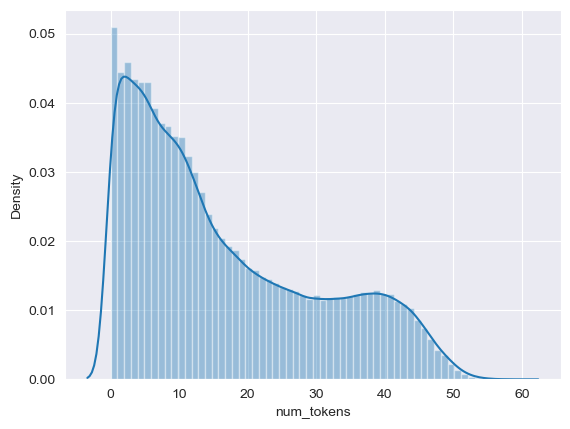

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(clean_display_txt.num_tokens, bins= clean_display_txt.num_tokens.nunique());
plt.show()

/Users/ipreoteasa/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


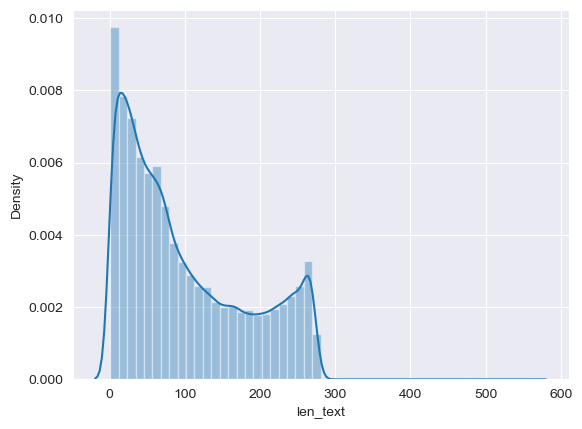

In [26]:
sns.distplot(clean_display_txt.len_text,);
plt.show()

You'll note of course that the max nr of characters seems to far outstrip that of Twitter's limits. This is due to non-text characters and how they are encoded in utf-8 format (e.g. emojis, which in utf8, often count as more than 1 character). 

In [27]:
pd.DataFrame({'len_text': clean_display_txt['len_text'].describe(), 'num_tokens' : clean_display_txt['num_tokens'].describe()})

,len_text,num_tokens
count,256186.000000,256186.000000
mean,99.621388,16.485706
std,82.041671,13.698216
min,1.000000,0.000000
25%,31.000000,5.000000
50%,73.000000,12.000000
75%,160.000000,26.000000
max,560.000000,59.000000


In [29]:
clean_display_txt['num_tokens'].value_counts(True).head(5).sum()

0.2238646920596754

Ok, so clearly we would loose a great deal of noise if we just removed those rows where there are very few tokens. It is also better at this stage to remove via tokens instead of just plain text, since the tokenizer will also reduce the total nr of characters.
I will remove everything less than the 25th quantile (5 tokens),  i.e. removing 22% of the rows.
This will account for most of the tweets that are just image uploads or very short reactions, however it still leaves us with 209'666 rows of data. 

In [34]:
final_display_txt = clean_display_txt.loc[clean_display_txt.num_tokens>=4]
final_display_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209666 entries, 2 to 265517
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   209666 non-null  object 
 1   tweet_id                     209666 non-null  object 
 2   datetime                     209666 non-null  object 
 3   display_name                 209666 non-null  object 
 4   tweet_text                   209666 non-null  object 
 5   User_id                      209666 non-null  float64
 6   #likes                       209666 non-null  float64
 7   #retweets                    209666 non-null  float64
 8   #responses                   209666 non-null  float64
 9   language                     209666 non-null  object 
 10  extracted_twitter_handles    209666 non-null  object 
 11  extracted_URLs               209666 non-null  object 
 12  extracted_hashtags           209666 non-null  object 
 13 

/Users/ipreoteasa/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


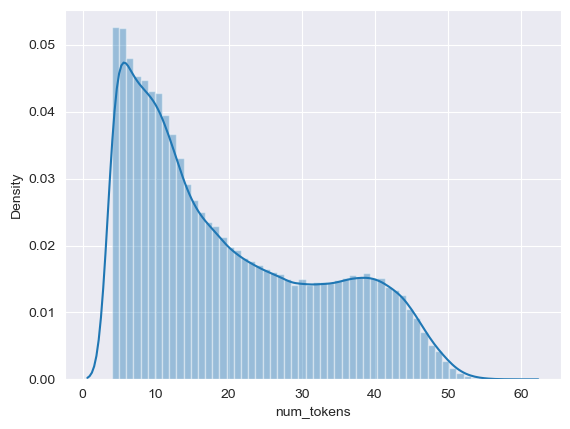

In [35]:
sns.distplot(final_display_txt.num_tokens, bins= final_display_txt.num_tokens.nunique());
plt.show()

In [36]:
# we'll now save this as the final version to be used for topic modelling 
# final_display_txt.to_csv('data/clean/clean_text_and_metadata.csv')
final_display_txt[['tweet_id', 'clean_tweet_text']].to_csv('data/clean/features/text_for_topics.csv')

In [37]:
final_display_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209666 entries, 2 to 265517
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   209666 non-null  object 
 1   tweet_id                     209666 non-null  object 
 2   datetime                     209666 non-null  object 
 3   display_name                 209666 non-null  object 
 4   tweet_text                   209666 non-null  object 
 5   User_id                      209666 non-null  float64
 6   #likes                       209666 non-null  float64
 7   #retweets                    209666 non-null  float64
 8   #responses                   209666 non-null  float64
 9   language                     209666 non-null  object 
 10  extracted_twitter_handles    209666 non-null  object 
 11  extracted_URLs               209666 non-null  object 
 12  extracted_hashtags           209666 non-null  object 
 13 

In [38]:
final_display_txt['datetime'] = pd.to_datetime(final_display_txt['datetime'], errors='coerce')

# now we want a very simple before and after ElonMusk's tweet proposing elections in Ukraine
cutoff_date = pd.to_datetime('2022-10-03 16:15:43+00:00',)


# now adding a filter column: stating whether a date is before or after this tweet. 
final_display_txt['Before_or_after_controversy'] = final_display_txt['datetime'].apply(lambda x : fn.is_it_before_or_after(x, cutoff_date))
final_display_txt.to_csv('data/clean/clean_text_and_metadata.csv')

/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_92282/496216866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_display_txt['datetime'] = pd.to_datetime(final_display_txt['datetime'], errors='coerce')
/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_92282/496216866.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_display_txt['Before_or_after_controversy'] = final_display_txt['datetime'].apply(lambda x : fn.is_it_before_or_after(x, cutoff_date))


In [39]:
final_display_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209666 entries, 2 to 265517
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   Unnamed: 0                   209666 non-null  object             
 1   tweet_id                     209666 non-null  object             
 2   datetime                     209666 non-null  datetime64[ns, UTC]
 3   display_name                 209666 non-null  object             
 4   tweet_text                   209666 non-null  object             
 5   User_id                      209666 non-null  float64            
 6   #likes                       209666 non-null  float64            
 7   #retweets                    209666 non-null  float64            
 8   #responses                   209666 non-null  float64            
 9   language                     209666 non-null  object             
 10  extracted_twitter_handles    209

In [41]:
final_display_txt.head(1)

,Unnamed: 0.1,Unnamed: 0,tweet_id,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text,Before_or_after_controversy,num_tokens,len_text
0,2,2,1580601578310230016,2022-10-13 16:49:17+00:00,elonmusk,@JohnnaCrider1 Envy has driven him to madness,44196397.0,5344.0,292.0,448.0,en,['@JohnnaCrider1'],[],[],Envy has driven him to madness,After,6,30


In [66]:
final_display_txt=pd.read_csv('data/clean/clean_text_and_metadata.csv')
final_display_txt.datetime = pd.to_datetime(final_display_txt.datetime)

In [7]:
final_2022 = final_display_txt.loc[final_display_txt.datetime>=pd.to_datetime('2022-08-01 00:00:00+00:00')]


In [68]:
len(final_display_txt.loc[final_display_txt.display_name=='elonmusk'])
df = final_display_txt.copy()

In [69]:
df.display_name.value_counts()

Techmeme           1000
nypost             1000
Reuters            1000
EpochTimes         1000
NewsfromScience     999
                   ... 
boringcompany        62
muskQu0tes           61
Xu0P5C4rMmMKUdu      60
NASAEarthMars        50
CChomp13             34
Name: display_name, Length: 281, dtype: int64

In [78]:
mention_musk = df.loc[df.extracted_twitter_handles.apply(lambda x : '@elonmusk' in x if pd.isnull(x)==False else False)] 
musk_post = df.loc[df.display_name=='elonmusk']

mention_musk['By_or_at_Musk'] = 'Mentions @elonmusk'
musk_post['By_or_at_Musk'] = 'By @elonmusk'

tdf = pd.concat([mention_musk, musk_post], axis=0)

# drop any rows that have null text, which removes over 1k rows
tdf = tdf.loc[~tdf.clean_tweet_text.isna()]
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20375 entries, 724 to 626
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   Unnamed: 0.1                 20375 non-null  int64              
 1   Unnamed: 0                   20375 non-null  int64              
 2   tweet_id                     20375 non-null  int64              
 3   datetime                     20375 non-null  datetime64[ns, UTC]
 4   display_name                 20375 non-null  object             
 5   tweet_text                   20375 non-null  object             
 6   User_id                      20375 non-null  float64            
 7   #likes                       20375 non-null  float64            
 8   #retweets                    20375 non-null  float64            
 9   #responses                   20375 non-null  float64            
 10  language                     20375 non-null  o

/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_6407/2797443984.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mention_musk['By_or_at_Musk'] = 'Mentions @elonmusk'
/var/folders/z8/91655qv97wdf50fs2d98cnfc0000gp/T/ipykernel_6407/2797443984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  musk_post['By_or_at_Musk'] = 'By @elonmusk'


In [79]:
tdf.By_or_at_Musk.value_counts()

Mentions @elonmusk    19748
By @elonmusk            627
Name: By_or_at_Musk, dtype: int64

In [96]:
from textwrap import wrap

tdf_melt = tdf.iloc[:, 2:].set_index('tweet_id')
tdf_melt = tdf_melt.loc[tdf_melt.datetime>=pd.to_datetime('2022-01-01 00:00:00+00:00')]
tdf_melt.rename({'#likes': 'Number of likes',	'#retweets': 'Number of retweets',	'#responses': 'Number of responses'}, axis=1, inplace=True)
tdf_melt = tdf_melt.melt(id_vars = ['datetime', 'display_name', 
                                    'tweet_text','By_or_at_Musk'], 
                        value_vars =  ['Number of likes',	'Number of retweets', 'Number of responses'])

tdf_melt['tweet_text'] = tdf_melt.tweet_text.apply(lambda x : '\n'.join(wrap(x, 30)).replace('\n', '<br>') )
tdf_melt['tweet_text'] = tdf_melt.apply(lambda x : 'by <b>' + x['display_name']+'</b>' +': '+ x['tweet_text'], axis=1)
tdf_melt.to_csv('data/viz/tweet_stats_over_time.csv')
tdf_melt.head()

AttributeError: 'DataFrame' object has no attribute 'clean_tweet_text'

In [91]:
tdf_melt.By_or_at_Musk.value_counts()

Mentions @elonmusk    54411
By @elonmusk           1881
Name: By_or_at_Musk, dtype: int64

In [27]:
final_2022_df = tdf.loc[tdf.datetime>=pd.to_datetime('2022-09-01 00:00:00+00:00')]


In [28]:
len(final_2022_df)

12037

In [29]:

# len(final_2022_df)
len(final_2022_df.loc[final_2022_df.display_name=='elonmusk'])

300

In [38]:
final_2022_df.to_csv('data/clean/dashboard_data.csv')

In [39]:
final_2022_df.head(1)

,Unnamed: 0.1,Unnamed: 0,tweet_id,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text,Before_or_after_controversy,num_tokens,len_text,By_or_at_Musk
724,1149,1149,1580168615357140992,2022-10-12 12:08:50+00:00,dcherring,@elonmusk My favorite (least favorite) is \n O...,44909288.0,1.0,0.0,0.0,en,['@elonmusk'],[],[],My favorite least favorite is ONLY TWO IDEAS,After,8,45,Mentions @elonmusk


In [34]:
#saving final data that will be used for topic modelling
final_2022_df[['tweet_id', 'clean_tweet_text']].to_csv('data/clean/features/text_for_topics_post_Aug22.csv')
final_2022_df[['tweet_id','datetime']].to_csv('data/clean/features/datetime_for_topics_post_Aug22.csv')

In [37]:
final_2022_df.language.value_counts(True)

en     0.989782
nl     0.001495
fr     0.000997
es     0.000914
hu     0.000831
und    0.000748
et     0.000665
ca     0.000582
de     0.000498
sv     0.000415
ro     0.000415
pt     0.000415
tl     0.000415
da     0.000332
it     0.000332
in     0.000249
no     0.000166
ht     0.000166
vi     0.000083
cy     0.000083
is     0.000083
sl     0.000083
lt     0.000083
ja     0.000083
eu     0.000083
Name: language, dtype: float64